# Handle Imbalanced Dataset

## Exploratory Data Analysis

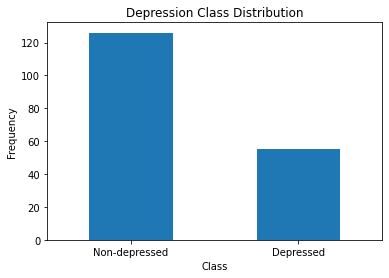

The ratio of negative to positive cases is 2.29.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Split the dataset
There are 2 reasons for splitting the dataset first:
1. We need to convert transcripts to word embeddings. The tokenizer should only be trained on the train set, instead of the entire corpus.
2. Due to an imbalanced dataset, we will be applying oversampling techniques later. Splitting first prevents the possibility of the exact same observations being present in both the train and test sets, which could lead to overfitting and poor generalization to the test data.

In [2]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(df.Transcript, df.PHQ_Binary, test_size=0.2, random_state=42)

## Convert transcripts to padded sequences

In [3]:
# Tokenization and padding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_raw)
vocab_size = len(tokenizer.word_index) + 1

Using TensorFlow backend.


In [4]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen)
    
    return X_mat

In [5]:
X_train_mat = prepare(X_train_raw)
X_test = prepare(X_test_raw)

X_train_mat.shape, X_test.shape

((144, 1000), (37, 1000))

## Oversampling
We will be using oversampling techniques instead of undersampling because our dataset given is very small and we do not want to discard any data.

In [6]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


In [7]:
from imblearn.over_sampling import RandomOverSampler

# the ratio of minority class to majority class will be 1 after resampling
oversampling = RandomOverSampler(sampling_strategy=1)

X_train, y_train = oversampling.fit_sample(X_train_mat, y_train_raw)

X_train.shape, y_train.shape

((200, 1000), (200,))

Now we have `X_train`, `X_test`, `y_train`, `y_test` ready to be used for model training and testing.

# More preprocessing

## Data Normalization
Most classifiers work best if data is normalized.

In [8]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

X_train_norm = x_scaler.transform(X_train)
X_test_norm = x_scaler.transform(X_test)

## Evaluation metrics
1. We will not be using `accuracy_score` as a metric because it is almost universally inappropriate for imbalanced classification. A high accuracy is achievable by a no-skill model that only predicts the majority class.
2. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR at the risk of getting a poorer `f1_score` or `roc_auc_score`
3. `balanced_accuracy_score` might be another suitable metric. It computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity and specificity.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

## Run model

In [10]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Decision Tree

AUC is:  0.6520979020979021
              precision    recall  f1-score   support

           0       0.83      0.58      0.68        26
           1       0.42      0.73      0.53        11

    accuracy                           0.62        37
   macro avg       0.63      0.65      0.61        37
weighted avg       0.71      0.62      0.64        37

Confusion Matrix: 
 [[15 11]
 [ 3  8]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=26)

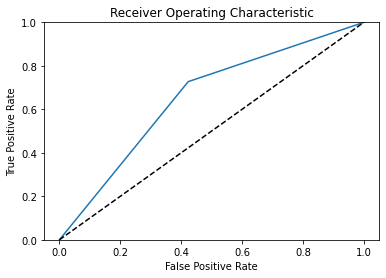

In [11]:
from sklearn.tree import DecisionTreeClassifier

def find_best_tree_model(upper_depth, upper_leaf):
    best_model = None
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            recall = recall_score(y_test, y_pred)
            
            if recall > best_recall:
                best_recall = recall
                best_model = model
                
    return best_model

best_tree_model = find_best_tree_model(80, 30)

run_model(best_tree_model, X_train, X_test, y_train, y_test)

## SVM with grid search

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    5.0s finished


AUC is:  0.5402097902097902
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        26
           1       0.38      0.27      0.32        11

    accuracy                           0.65        37
   macro avg       0.55      0.54      0.54        37
weighted avg       0.62      0.65      0.63        37

Confusion Matrix: 
 [[21  5]
 [ 8  3]]
{'C': 1, 'kernel': 'linear'}


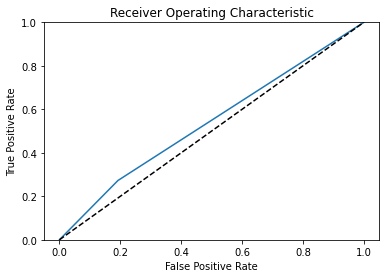

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='recall', verbose=1, n_jobs=4)

best_svm_model = run_model(svm_model_cv, X_train_norm, X_test_norm, y_train, y_test)
print(best_svm_model.best_params_)